In [2]:
import os, warnings, json
import tensorflow as tf
import re, torch, timm, random, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
from collections import defaultdict
from textwrap import wrap, shorten
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, Add, LSTM, LayerNormalization, MultiHeadAttention
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
pd.set_option("display.max_colwidth", None)   
pd.set_option("display.max_columns", None) 

data = pd.read_csv("./data/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


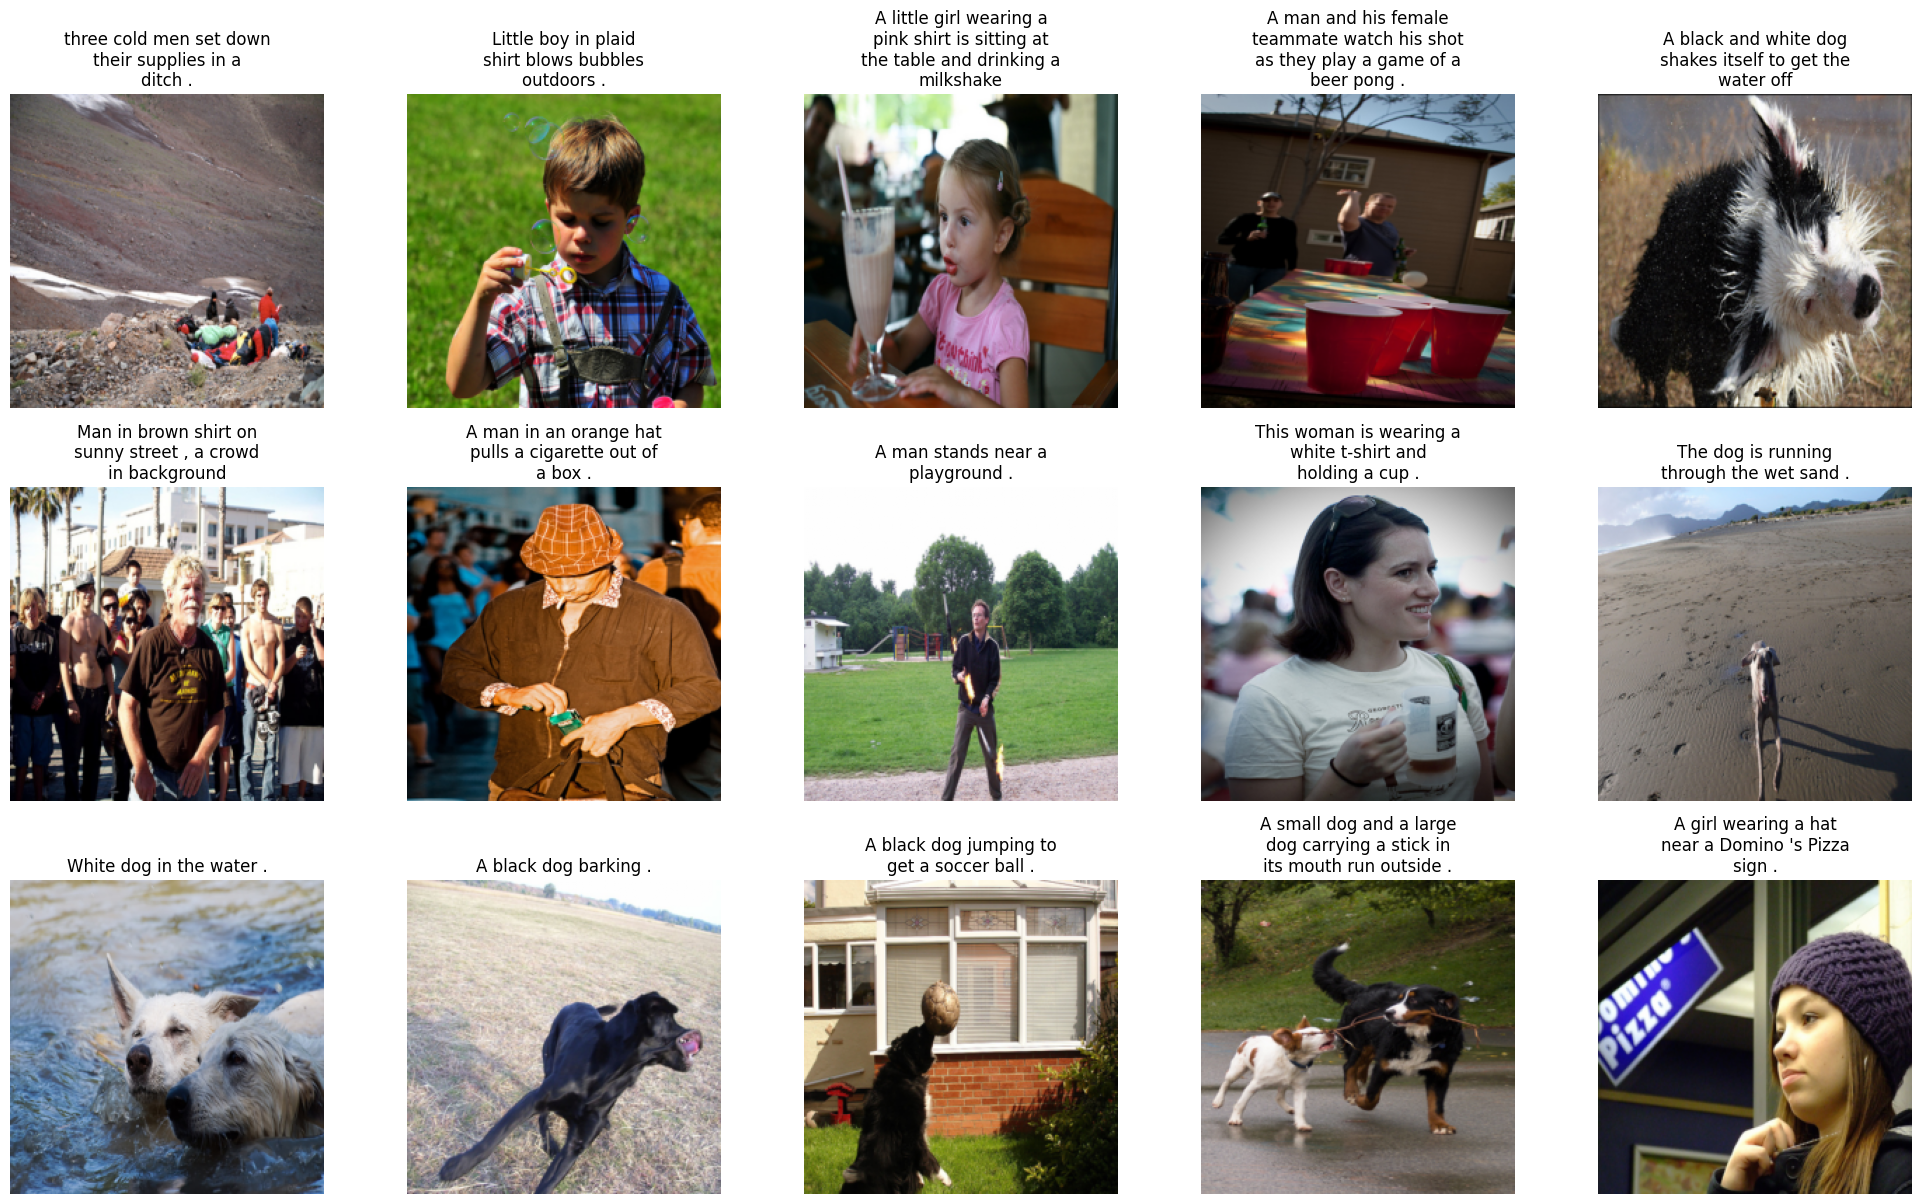

In [4]:
def read_image(path, img_size=224):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    img = Image.open(path).convert("RGB")
    img = transform(img)
    return img.permute(1, 2, 0).numpy()

def display_images(temp_df, max_images=15, img_size=224):
    temp_df = temp_df.sample(min(max_images, len(temp_df))).reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    
    for i in range(15):
        plt.subplot(5, 5, i+1); plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = read_image(f"./data/images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 24))); plt.axis("off")
    plt.tight_layout(); plt.show()

display_images(temp_df=data.sample(15))

In [ ]:
def clean_caption(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9à-ỹÀ-Ỹ\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_captions(file_path):
    captions_dict = defaultdict(list)
    with open(file_path, 'r', encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            parts = line.strip().split(',')
            if len(parts) == 2:
                img_name = parts[0].strip()
                caption = f"startseq {clean_caption(parts[1])} endseq"
                if 2 < len(caption.split()) <= 40 and caption not in captions_dict[img_name]:
                    captions_dict[img_name].append(caption)
    return dict(captions_dict)

In [ ]:
caption_file = "./data/captions.txt"
captions_dict = load_captions(caption_file)
image_dir = "./data/images"

keys = list(captions_dict.keys())

def show_captions_dict(d, keys, n_head=1, n_tail=1, width=80):
    result = {}
    for k in keys[:n_head]:
        result[k] = [shorten(c, width=width, placeholder="...") for c in d[k]]
    if len(keys) > n_head + n_tail:
        result["..."] = ["..."]
    for k in keys[-n_tail:]:
        result[k] = [shorten(c, width=width, placeholder="...") for c in d[k]]
    print("captions_dict =", json.dumps(result, indent=4, ensure_ascii=False))
        
show_captions_dict(captions_dict, keys, n_head=1, n_tail=1, width=80)

In [ ]:
# model_resnet = timm.create_model('resnet50', pretrained=True, num_classes=0)  
# model_resnet.eval()

# transform_resnet = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225]
#     )
# ])

# def extract_features_resnet(img_path):
#     img = Image.open(img_path).convert('RGB')
#     img_tensor = transform_resnet(img).unsqueeze(0)  
#     with torch.no_grad():
#         features = model_resnet(img_tensor) 
#     return features.squeeze(0).numpy()  
    
# features_dict = {}
# for img_name in tqdm(captions_dict):
#     if os.path.exists(os.path.join(image_dir, img_name)):
#         features_dict[img_name] = extract_features_resnet(os.path.join(image_dir, img_name))

# with open("./cache/image_featuresResnet.pkl", "wb") as f:
#     pickle.dump(features_dict, f)

In [ ]:
with open("./cache/image_featuresResnet.pkl", "rb") as f:
    features_dict = pickle.load(f)

keys = list(features_dict.keys())

def shorten_array(arr, head=2, tail=2):
    arr = arr.tolist()
    if len(arr) <= head + tail:
        return arr
    return arr[:head] + ["..."] + arr[-tail:]

def show_features_dict(d, keys, n_head=3, n_tail=3):
    result = {}
    for k in keys[:n_head]:
        result[k] = shorten_array(d[k])
    if len(keys) > n_head + n_tail:
        result["..."] = ["..."]
    for k in keys[-n_tail:]:
        result[k] = shorten_array(d[k])
    print("features_dict = {")
    for k, v in result.items():
        print(f'    "{k}": {json.dumps(v, ensure_ascii=False, separators=(",", ": "))},')
    print("}")

show_features_dict(features_dict, keys, n_head=3, n_tail=3)

In [ ]:
def create_tokenizer(captions_dict):
    all_captions = [cap for caps in captions_dict.values() for cap in caps]

    tokenizer = Tokenizer(oov_token="<unk>", filters='')
    tokenizer.fit_on_texts(all_captions)

    word_index = tokenizer.word_index
    index_word = {idx: word for word, idx in word_index.items()}
    
    return tokenizer, word_index, index_word

tokenizer, word_index, index_word = create_tokenizer(captions_dict)

In [ ]:
def show_word_index(d, head=5, tail=5, per_line=5):
    items = list(d.items())
    if len(items) > head + tail:
        items = items[:head] + [("...", "...")] + items[-tail:]
    lines = [
        "  " + ", ".join(f'"{k}": {v}' for k, v in items[i:i+per_line])
        for i in range(0, len(items), per_line)
    ]
    print("word_index =", "{\n" + ",\n".join(lines) + "\n}")

show_word_index(word_index, head=10, tail=10, per_line=8)

In [ ]:
# def load_fasttext_embedding(filepath, word_index, embed_dim=300):
#     embeddings_index = {}
#     with open(filepath, encoding='utf-8') as f:
#         next(f)
#         for i, line in enumerate(f):
#             values = line.rstrip().split(' ')
#             word = values[0]
#             vector = np.asarray(values[1:], dtype='float32')
#             embeddings_index[word] = vector

#     embedding_matrix = np.random.uniform(-0.05, 0.05, (len(word_index) + 1, embed_dim))
#     for word, i in word_index.items():
#         vector = embeddings_index.get(word)
#         if vector is not None:
#             embedding_matrix[i] = vector

#     return embedding_matrix

# embedding_matrix = load_fasttext_embedding('./data/cc.en.300.vec', word_index, embed_dim=300)

# with open("./cache/embedding_matrix_ft.pkl", "wb") as f:
#     pickle.dump(embedding_matrix, f)

In [ ]:
with open("./cache/embedding_matrix_ft.pkl", "rb") as f:
    embedding_matrix = pickle.load(f)

def show_embedding_matrix(mat, head=3, tail=3, vec_head=3, vec_tail=3):
    n, d = mat.shape

    def format_vec(v):
        return (
            "[" + ", ".join(f"{x:.4f}" for x in v[:vec_head]) +
            (", ..., " if d > vec_head + vec_tail else ", ") +
            ", ".join(f"{x:.4f}" for x in v[-vec_tail:]) + "]"
            if d > vec_head + vec_tail else
            np.array2string(v, precision=4, separator=", ")
        )

    rows = [f"  {format_vec(v)}" for v in mat[:head]]
    if n > head + tail: rows.append("  ...")
    rows += [f"  {format_vec(v)}" for v in mat[-tail:]]

    print("embedding_matrix = [\n" + "\n".join(rows) + "\n]")

show_embedding_matrix(embedding_matrix, head=3, tail=3, vec_head=3, vec_tail=3)

In [ ]:
# X_img, X_seq, y = [], [], []
# for img_id, caps in captions_dict.items():
#     feature = features_dict.get(img_id)
#     if feature is None: continue
#     for cap in caps:
#         seq = [word_index[word] for word in cap.split() if word in word_index]
#         for i in range(1, len(seq)):
#             X_img.append(feature)
#             X_seq.append(pad_sequences([seq[:i]], maxlen=40, padding='post')[0])
#             y.append(seq[i])

# X_img = np.array(X_img)
# X_seq = np.array(X_seq)
# y = np.array(y).reshape(-1, 1)

# X_img_train, X_img_val, X_seq_train, X_seq_val, y_train, y_val = train_test_split(
#     X_img, X_seq, y, test_size=0.1, random_state=42
# )

In [ ]:
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.layers import Layer

@register_keras_serializable()
class ExpandDimsLayer(Layer):
    def call(self, inputs):
        return tf.expand_dims(inputs, 1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1, input_shape[1])

@register_keras_serializable()
class ReduceMeanLayer(Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

In [ ]:
def build_model(vocab_size, max_len, embedding_matrix):
    embed_dim = embedding_matrix.shape[1]

    # ===== IMAGE ENCODER =====
    inputs1 = Input(shape=(2048,))
    x1 = Dropout(0.2)(inputs1)
    x1 = Dense(embed_dim, activation='relu')(x1)
    x1 = LayerNormalization()(x1)
    x1_exp = ExpandDimsLayer()(x1)

    # ===== TEXT DECODER =====
    inputs2 = Input(shape=(max_len,))
    x2 = Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        weights=[embedding_matrix],
        trainable=False,
        mask_zero=True,
    )(inputs2)
    x2 = Dropout(0.3)(x2)
    x2 = LSTM(256, return_sequences=True, recurrent_dropout=0.2)(x2)
    x2 = Dense(embed_dim)(x2)

    # ===== CROSS ATTENTION =====
    attn = MultiHeadAttention(num_heads=4, key_dim=embed_dim)(x1_exp, x2)
    attn = LayerNormalization()(attn + x1_exp)
    attn = ReduceMeanLayer()(attn)

    # ===== MERGE IMAGE & ATTENTION =====
    merged = Add()([attn, x1])
    x = Dense(128, activation='relu')(merged)
    output = Dense(vocab_size, activation='softmax')(x)

    model = Model(inputs=[inputs1, inputs2], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model

model = build_model(vocab_size=len(word_index) + 1, max_len=40, embedding_matrix=embedding_matrix); model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="./assets/caption_resf_model.png", show_shapes=True, show_layer_names=True)

In [ ]:
# callbacks = [
#     tf.keras.callbacks.ModelCheckpoint("./models/caption_resf.keras", save_best_only=True, monitor='val_loss'),
#     tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss', restore_best_weights=True),
#     tf.keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.1,
#         patience=3,
#         min_lr=1e-6,
#         verbose=1
#     )
# ]

# history = model.fit(
#     [X_img_train, X_seq_train], y_train,
#     validation_data=([X_img_val, X_seq_val], y_val),
#     epochs=50,
#     batch_size=512,
#     callbacks=callbacks
# )

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('./models/caption_resf.keras')

In [ ]:
def generate_caption_beam_search(model, image_feature, tokenizer, index_word, beam_size=3, max_len=40, repeat_threshold=3):
    def remove_repeated_phrases(tokens, n=2):
        filtered = []
        for i in range(len(tokens)):
            if i < n * 2 or tokens[i-n:i] != tokens[i-n*2:i-n]:
                filtered.append(tokens[i])
        return filtered

    start_seq = [tokenizer.word_index['startseq']]
    sequences = [(start_seq, 0.0)]

    for _ in range(max_len):
        all_candidates = []
        for seq, score in sequences:
            if len(seq) > 1 and index_word.get(seq[-1], '') == 'endseq':
                all_candidates.append((seq, score))
                continue

            padded = pad_sequences([seq], maxlen=max_len, padding='post')
            yhat = model.predict([image_feature.reshape((1, -1)), padded], verbose=0)[0]
            yhat = np.log(yhat + 1e-8)

            top_candidates = np.argsort(yhat)[-beam_size:][::-1]
            for word_id in top_candidates:
                new_seq = seq + [word_id]
                new_score = score + yhat[word_id]

                last_words = [index_word.get(wid, '') for wid in new_seq[-repeat_threshold:]]
                if len(last_words) == repeat_threshold and len(set(last_words)) == 1:
                    continue
                if len(new_seq) >= 4:
                    bigram1 = (index_word.get(new_seq[-4], ''), index_word.get(new_seq[-3], ''))
                    bigram2 = (index_word.get(new_seq[-2], ''), index_word.get(new_seq[-1], ''))
                    if bigram1 == bigram2:
                        continue
                all_candidates.append((new_seq, new_score))

        if not all_candidates:
            break
        sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_size]

    best_seq = sequences[0][0]
    caption = [index_word.get(i, '') for i in best_seq if i in index_word]
    caption = [w for w in caption if w not in ('startseq', 'endseq', '<unk>', '')]

    return ' '.join(remove_repeated_phrases(caption, n=2))

In [ ]:
def display_image_with_caption(img_path, generated_caption, ground_truth_captions):
    img = Image.open(img_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img); plt.axis('off')

    gt_text = '\n'.join([f"- {cap}" for cap in ground_truth_captions])

    plt.title(f"Caption Sinh: {generated_caption}\n\nCaption Gốc:\n{gt_text}", fontsize=10)
    plt.tight_layout(); plt.show()

In [ ]:
example_img = list(features_dict.keys())[20]
example_path = os.path.join(image_dir, example_img)
example_feature = features_dict[example_img]

caption = generate_caption_beam_search(model, example_feature, tokenizer, index_word)

ground_truths = captions_dict[example_img]  
gt_cleaned = [
    ' '.join(w for w in cap.split() if w not in ('startseq', 'endseq', '<unk>'))
    for cap in ground_truths
]

display_image_with_caption(example_path, caption, gt_cleaned)